In [ ]:
!pip install langgraph langsmith

In [ ]:
!pip install langchain_groq langchain_community

In [ ]:
!pip install arxiv wikipedia

In [ ]:
from google.colab import userdata
Groq_Api_Key  = userdata.get('Groq_Api_Key')
Langsmith_Api_Key = userdata.get('Langsmith_Api_Key')


In [ ]:
import os
os.environ["GROQ_API_KEY"] = Groq_Api_Key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_Api_KeyT"] = Langsmith_Api_Key
os.environ["LANGCHAIN_Project"] = "Course_Langgraph "

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

Working With Tools

In [ ]:
from langchain.utilities import WikipediaAPIWrapper , ArxivAPIWrapper
from langchain.tools import WikipediaQueryRun , ArxivQueryRun

In [ ]:
arxiv_api_wrapper = ArxivAPIWrapper(top_k_results=2 , doc_content_chars=500)
arxiv_query_run = ArxivQueryRun(api_wrapper=arxiv_api_wrapper)
wikipedia_api_wrapper = WikipediaAPIWrapper(top_k_results=2 , doc_content_chars_max=500)
wikipedia_query_run = WikipediaQueryRun(api_wrapper=wikipedia_api_wrapper)


In [ ]:
wikipedia_query_run.invoke("Who is Godfather of AI")

'Page: Geoffrey Hinton\nSummary: Geoffrey Everest Hinton (born 6 December 1947) is a British-Canadian computer scientist, cognitive scientist, cognitive psychologist, known for his work on artificial neural networks which earned him the title as the "Godfather of AI".\nHinton is University Professor Emeritus at the University of Toronto. From 2013 to 2023, he divided his time working for Google (Google Brain) and the University of Toronto, before publicly announcing his departure from Google in May'

In [ ]:
arxiv_query_run.invoke("attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for skipping the attention layers.\n\n

In [ ]:
tools = [wikipedia_query_run]

In [ ]:
llm_with_tools = llm.bind_tools(tools = tools)

In [ ]:
class State(TypedDict):
  message : Annotated[list , add_messages]

In [ ]:
graph_builder  = StateGraph(State)

In [ ]:
from langchain_groq import ChatGroq
llm  = ChatGroq(groq_api_key=Groq_Api_Key , model = "Gemma2-9b-It")

In [ ]:
def chatbot(state = State):
  return{messages:[llm_with_tools.invoke(state["messages"])]}

In [ ]:
from langgraph.prebuilt import ToolNode , tools_condition

In [ ]:
graph_builder.add_node("chatbot" , chatbot)
graph_builder.add_edge(START , 'chatbot')
tool_node = ToolNode(tools = tools)

graph_builder.add_node("tools" , tool_node)

graph_builder.add_conditional_edges("chatbot" , tools_condition)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot" , END)

In [ ]:
graph = graph_builder.compile()

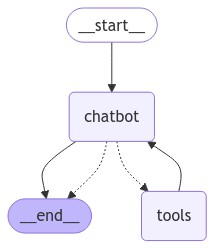

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
user_input="Hi there!, My name is John"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

InvalidUpdateError: Must write to at least one of ['message']

In [ ]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values")

for event in events:
    print(event["messages"])

InvalidUpdateError: Must write to at least one of ['message']